In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pylab import rcParams
import pylab

In [5]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf
from matplotlib.pyplot import rc
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd 
from tensorflow.keras.losses import binary_crossentropy, mse, categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.metrics import TruePositives, FalsePositives, FalseNegatives

In [79]:
import cv2 as cv
from math import ceil
from sklearn.utils import shuffle

In [4]:
dt = np.dtype(np.float32)
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 3

In [90]:
def generator(batch_size=50):
    while True:
        for j in range(batch_size):
            Xs = []
            Ys = []
            count = 0
            
            while count < 100:
                
                day_or_night = random.randint(0,1)

                if day_or_night == 0: 
                    folder_day = random.randint(1,13)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/dayTrain/dayClip{}/frameAnnotationsBOX.csv'.format(folder_day)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                else:
                    folder_night = random.randint(1,5)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/nightTrain/nightClip{}/frameAnnotationsBOX.csv'.format(folder_night)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                # choose picture 
                i = random.randint(0, len(csv_file.iloc[:,0].unique())-1)# choose random number of picture in folder
                full_pic_name = csv_file.iloc[:,0].unique()[i] # with index above choose full name picture 
                pic_name = csv_file.iloc[:,0].unique()[i].split('/')[1] # with index above choose picture 

                if day_or_night == 0:
                    path_to_img = '/Users/stanislav/Downloads/archive/dayTrain/dayTrain/dayClip{}/frames/'.format(folder_day) + pic_name
                else:
                    path_to_img = '/Users/stanislav/Downloads/archive/nightTrain/nightTrain/nightClip{}/frames/'.format(folder_night) + pic_name

                img = cv.imread(path_to_img)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

                # find coordinates
                number_of_same_pic = len(csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[:,0]) # how many pic with same name
                img = cv.copyMakeBorder(img, 200, 200, 200, 200, cv.BORDER_REPLICATE) 
                
                # blobbing
                params = cv.SimpleBlobDetector_Params()
                params.minThreshold = 1
                params.maxThreshold = 255
                params.filterByArea = True
                params.minArea = 100 # for day it was 300
                #params.maxArea = 1500
                params.filterByCircularity = False
                params.filterByConvexity = False
                params.filterByInertia = False

                detector = cv.SimpleBlobDetector_create(params)
                keypoints = detector.detect(img)

                kps = np.array([key for key in keypoints])
                #print(kps)

                #im_with_keypoints = cv.drawKeypoints(img, keypoints, np.array([]), (0, 0, 255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                

                for i in range(number_of_same_pic):
                    if count < 100:
                        #appear = True
                        # coors of box
                        x1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,2]+200
                        y1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,3]+200
                        x2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,4]+200
                        y2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,5]+200
                        
                        # condition for keypoins which are not boxes - TAKES MUCH TIME
                        for key in keypoints:
                            keypoints = [key for key in keypoints if not ((x1 < key.pt[0] < x2) and (y1 < key.pt[1] < y2))]     

                        # crop image a little bigger than box 
                        cropped_img = img[y1-100:y2+100, x1-100:x2+100]
                        
                        
                        new_x1 = 100
                        new_y1 = 100
                        new_x2 = 100 + (x2-x1)
                        new_y2 = 100 + (y2-y1)

                        w = cropped_img.shape[1]
                        h = cropped_img.shape[0]

                        Rx = (64 / w)
                        Ry = (64 / h)
                        
                        x1 = ceil(new_x1*Rx)
                        y1 = ceil(new_y1*Ry) 
                        x2 = ceil(new_x2*Rx)
                        y2 = ceil(new_y2*Ry)

                        cropped_img = cv.resize(cropped_img, (64, 64))
                        cropped_img = cropped_img.reshape(1, 64, 64, 3)

                        box = np.array([1, x1, y1, x2, y2], dtype=dt)
                        
                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)
                        #box = box.reshape(5, 1)
                        
                        count += 1

                for k in range(len(keypoints)):
                    if count < 100:
                        #appear = False
                        k_x1 = int(round(keypoints[k].pt[0]-100))
                        k_y1 = int(round(keypoints[k].pt[1]-100))
                        k_x2 = int(round(keypoints[k].pt[0]+100))
                        k_y2 = int(round(keypoints[k].pt[1]+100))

                        cropped_img = img[k_y1:k_y2, k_x1:k_x2]
                        cropped_img = cv.resize(cropped_img, (64, 64))
                        cropped_img = cropped_img.reshape(1, 64, 64, 3)

                        box = np.array([0, 0, 0, 0, 0], dtype=dt)
                        #box = box.reshape(5, 1)

                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)

                        count += 1
                        
            Xs, Ys = shuffle(Xs, Ys)            
            yield Xs, Ys

In [365]:
def generator(batch_size=50):
    #while True:
        for j in range(1):
            Xs = []
            Ys = []
            count = 0
            
            while count < 10:
                
                day_or_night = random.randint(0,1)

                if day_or_night == 0: 
                    folder_day = random.randint(1,13)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/dayTrain/dayClip{}/frameAnnotationsBOX.csv'.format(folder_day)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                else:
                    folder_night = random.randint(1,5)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/nightTrain/nightClip{}/frameAnnotationsBOX.csv'.format(folder_night)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                # choose picture 
                i = random.randint(0, len(csv_file.iloc[:,0].unique())-1)# choose random number of picture in folder
                full_pic_name = csv_file.iloc[:,0].unique()[i] # with index above choose full name picture 
                pic_name = csv_file.iloc[:,0].unique()[i].split('/')[1] # with index above choose picture 

                if day_or_night == 0:
                    path_to_img = '/Users/stanislav/Downloads/archive/dayTrain/dayTrain/dayClip{}/frames/'.format(folder_day) + pic_name
                else:
                    path_to_img = '/Users/stanislav/Downloads/archive/nightTrain/nightTrain/nightClip{}/frames/'.format(folder_night) + pic_name

                img = cv.imread(path_to_img)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

                # find coordinates
                number_of_same_pic = len(csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[:,0]) # how many pic with same name
                img = cv.copyMakeBorder(img, 300, 300, 300, 300, cv.BORDER_REPLICATE) 
                
                # blobbing
                params = cv.SimpleBlobDetector_Params()
                params.minThreshold = 1
                params.maxThreshold = 255
                params.filterByArea = True
                params.minArea = 100 # for day it was 300
                #params.maxArea = 1500
                params.filterByCircularity = False
                params.filterByConvexity = False
                params.filterByInertia = False

                detector = cv.SimpleBlobDetector_create(params)
                keypoints = detector.detect(img)

                kps = np.array([key for key in keypoints])
                #print(kps)

                #im_with_keypoints = cv.drawKeypoints(img, keypoints, np.array([]), (0, 0, 255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                

                for i in range(number_of_same_pic):
                    if count < 10:
                        #appear = True
                        # coors of box
                        x1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,2]+300
                        y1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,3]+300
                        x2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,4]+300
                        y2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,5]+300
                        
                        # condition for keypoins which are not boxes - TAKES MUCH TIME
                        for key in keypoints:
                            keypoints = [key for key in keypoints if not ((x1 < key.pt[0] < x2) and (y1 < key.pt[1] < y2))]     

                        # crop image a little bigger than box 
                        cropped_img = img[y1-100:y2+100, x1-100:x2+100]
                        
                        
                        new_x1 = 100
                        new_y1 = 100
                        new_x2 = 100 + (x2-x1)
                        new_y2 = 100 + (y2-y1)

                        w = cropped_img.shape[1]
                        h = cropped_img.shape[0]

                        Rx = (64 / w)
                        Ry = (64 / h)
                        
                        x1 = ceil(new_x1*Rx)
                        y1 = ceil(new_y1*Ry) 
                        x2 = ceil(new_x2*Rx)
                        y2 = ceil(new_y2*Ry)

                        cropped_img = cv.resize(cropped_img, (64, 64))
                        #cropped_img = cropped_img.reshape(1, 64, 64, 3)

                        box = np.array([1, x1, y1, x2, y2], dtype=dt)
                        #box = box.reshape(5, 1)

                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)
                        
                        image_rect = cv.rectangle(cropped_img, (x1,y1), (x2,y2), (0,255,0), 1)
                        
                        print(box)
                        plt.imshow(image_rect)
                        plt.show()

                        count += 1
                keypoints = keypoints[-4:-1]
                for k in range(len(keypoints)):
                    if count < 10:
                        #appear = False
                        k_x1 = int(round(keypoints[k].pt[0]-150))
                        k_y1 = int(round(keypoints[k].pt[1]-150))
                        k_x2 = int(round(keypoints[k].pt[0]+150))
                        k_y2 = int(round(keypoints[k].pt[1]+150))

                        cropped_img = img[k_y1:k_y2, k_x1:k_x2]
                        cropped_img = cv.resize(cropped_img, (64, 64))
                        #cropped_img = cropped_img.reshape(1, 64, 64, 3)

                        box = np.array([0, 0, 0, 0, 0], dtype=dt)
                        #box = box.reshape(5, 1)

                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)
                        
                        print(box)
                        plt.imshow(cropped_img)
                        plt.show()

                        count += 1
                        
                        

[ 1. 31. 29. 34. 36.]


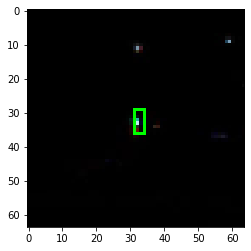

[ 1. 30. 29. 35. 36.]


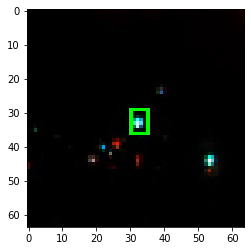

[ 1. 31. 29. 34. 36.]


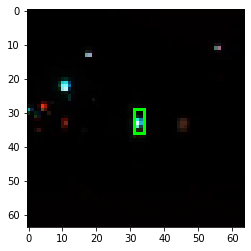

[ 1. 28. 24. 37. 41.]


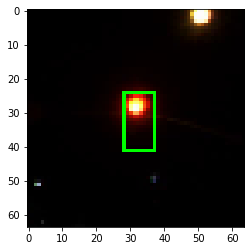

[ 1. 29. 26. 36. 39.]


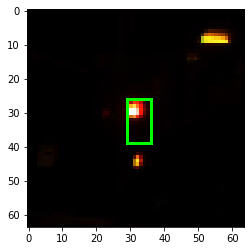

[ 1. 30. 28. 35. 37.]


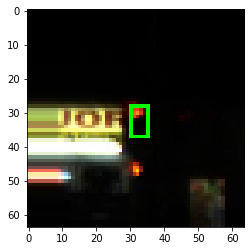

[ 1. 29. 27. 36. 38.]


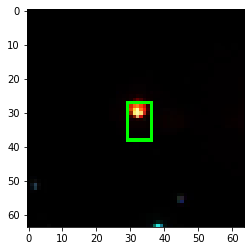

[0. 0. 0. 0. 0.]


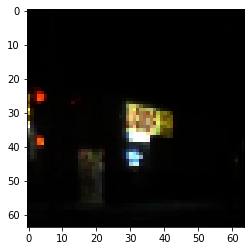

[ 1. 27. 27. 38. 38.]


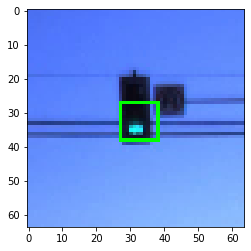

[ 1. 28. 26. 37. 39.]


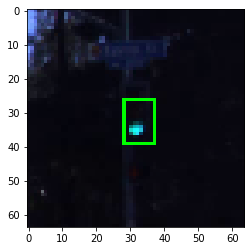

In [366]:
generator()

In [162]:
def custom_loss(y_true, y_pred):
    #print(y_true.shape, y_pred.shape)
    y_true = tf.reshape(y_true, [1, 5])
    y_pred = tf.reshape(y_pred, [1, 5])
    #print(y_true.shape, y_pred.shape)
    
    class_loss = binary_crossentropy(y_true[:, 0], y_pred[:, 0])
    # need make Euclidian distance loss here
    reg_loss = mse(y_true[:, 1:5], y_pred[:, 1:5])
    
    return class_loss + 2 * reg_loss * y_true[:, 0]

def make_model():
    input_layer = Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    layer_1 = Conv2D(32, (3, 3), activation='relu')(input_layer)

    layer_2 = Conv2D(32, (3, 3), activation='relu')(layer_1)
    layer_2 = MaxPooling2D(pool_size=(2, 2))(layer_2)

    
    layer_3 = Conv2D(64, (3, 3), activation='relu')(layer_2)
    layer_3 = MaxPooling2D(pool_size=(2, 2))(layer_3)
    
    layer_4 = Flatten()(layer_3)
    layer_4 = Dense(1000, activation='relu')(layer_4)
    
    layer_5 = Dense(200, activation='relu')(layer_4)
    
    out_1 = Dense(1, activation='sigmoid')(layer_5)
    out_2 = Dense(4, activation='linear')(layer_5)
    
    x = Concatenate()([out_1, out_2])
    
    model = Model(input_layer, x)
    model.compile(optimizer = Adam(learning_rate=0.0001), loss = custom_loss)
    
    return model

In [221]:
model_one = make_model()

In [275]:
history = model_one.fit(generator(),
              #validation_data=generator(),
              steps_per_epoch=50,
              epochs=50)

Epoch 1/50
50/50 [==============================] - 120s 2s/step - loss: 44.4791
Epoch 2/50
50/50 [==============================] - 119s 2s/step - loss: 78.9001
Epoch 3/50
50/50 [==============================] - 121s 2s/step - loss: 139.3145
Epoch 4/50
50/50 [==============================] - 119s 2s/step - loss: 37.0176
Epoch 5/50
50/50 [==============================] - 122s 2s/step - loss: 71.5863
Epoch 6/50
50/50 [==============================] - 119s 2s/step - loss: 55.1142
Epoch 7/50
50/50 [==============================] - 118s 2s/step - loss: 41.5064
Epoch 8/50
50/50 [==============================] - 118s 2s/step - loss: 52.5795
Epoch 9/50
50/50 [==============================] - 118s 2s/step - loss: 119.3562
Epoch 10/50
50/50 [==============================] - 118s 2s/step - loss: 94.5361
Epoch 11/50
50/50 [==============================] - 118s 2s/step - loss: 67.3298
Epoch 12/50
50/50 [==============================] - 119s 2s/step - loss: 34.6359
Epoch 13/50
50/50 [====

In [367]:
# move frist while
# also try to add negative sample
# change 2nd while on if
def predictor():
    #while True:
        for j in range(1):
            Xs = []
            Ys = []
            count = 0
            
            while count < 10:
                
                day_or_night = random.randint(0,1)

                if day_or_night == 0: 
                    folder_day = random.randint(1,13)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/dayTrain/dayClip{}/frameAnnotationsBOX.csv'.format(folder_day)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                else:
                    folder_night = random.randint(1,5)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/nightTrain/nightClip{}/frameAnnotationsBOX.csv'.format(folder_night)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

            
        # choose picture 
                i = random.randint(0, len(csv_file.iloc[:,0].unique())-1)# choose random number of picture in folder
                full_pic_name = csv_file.iloc[:,0].unique()[i] # with index above choose full name picture 
                pic_name = csv_file.iloc[:,0].unique()[i].split('/')[1] # with index above choose picture 

                if day_or_night == 0:
                    path_to_img = '/Users/stanislav/Downloads/archive/dayTrain/dayTrain/dayClip{}/frames/'.format(folder_day) + pic_name
                else:
                    path_to_img = '/Users/stanislav/Downloads/archive/nightTrain/nightTrain/nightClip{}/frames/'.format(folder_night) + pic_name


            # print picture
                img = cv.imread(path_to_img)

                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


            # find coordinates
                number_of_same_pic = len(csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[:,0]) # how many pic with same name
                img = cv.copyMakeBorder(img, 200, 200, 200, 200, cv.BORDER_REPLICATE) 
                
                
                
                
                # here I make BLOB DETECTION
                
                
                # blobbing
                params = cv.SimpleBlobDetector_Params()
                params.minThreshold = 1
                params.maxThreshold = 255
                params.filterByArea = True
                params.minArea = 100 # for day it was 300
                #params.maxArea = 1500
                params.filterByCircularity = False
                params.filterByConvexity = False
                params.filterByInertia = False


                detector = cv.SimpleBlobDetector_create(params)
                keypoints = detector.detect(img)

                kps = np.array([key for key in keypoints])
                #print(kps)

                #im_with_keypoints = cv.drawKeypoints(img, keypoints, np.array([]), (0, 0, 255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                

                for i in range(number_of_same_pic):
                    #if count < 64:
                        
                    # coors of box
                    x1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,2]+100
                    y1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,3]+100
                    x2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,4]+100
                    y2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,5]+100

                    # condition for keypoins which are not boxes
                    for key in keypoints:
                        keypoints = [key for key in keypoints if not ((x1 < key.pt[0] < x2) and (y1 < key.pt[1] < y2))]     

                    # crop image a little bigger than box 
                    cropped_img = img[y1-100:y2+100, x1-100:x2+100]
                    cropped_img = cv.resize(cropped_img, (64, 64))


                    #print(model_one.predict(np.array(cropped_img)))
                    x = np.expand_dims(cropped_img, 0) / 255.
                    print(model_one.predict(x)[0])
                    
                    plt.imshow(cropped_img)
                    plt.show()
                    #Xs.append(np.array(cropped_img) / 255.), Ys.append(np.array(box) / 64.)

                    count += 1
                                         
                for k in range(len(keypoints)):
                    if count < 10:
                        k_x1 = int(round(keypoints[k].pt[0]-100))
                        k_y1 = int(round(keypoints[k].pt[1]-100))
                        k_x2 = int(round(keypoints[k].pt[0]+100))
                        k_y2 = int(round(keypoints[k].pt[1]+100))
                                         
                        cropped_img = img[k_y1:k_y2, k_x1:k_x2]
                        cropped_img = cv.resize(cropped_img, (64, 64))
                        
                        #print(model_one.predict(np.array(cropped_img)))
                        z = np.expand_dims(cropped_img, 0) / 255.
                        print(model_one.predict(z)[0])
                        
                        plt.imshow(cropped_img)
                        plt.show()
                        #Xs.append(np.array(cropped_img) / 255.), Ys.append(np.array(box) / 64.)

                        count += 1
                        
                        
                

            #yield Xs, Ys

[ 0.26690435 44.633476   46.753384   50.239445   56.079628  ]


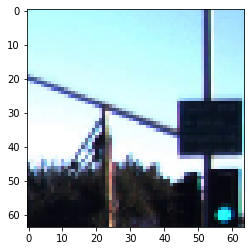

[ 0.19905466 40.354248   42.861664   45.242573   50.65501   ]


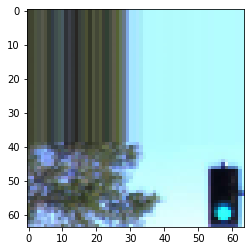

[ 0.25493246 25.820814   25.719063   31.777145   35.666027  ]


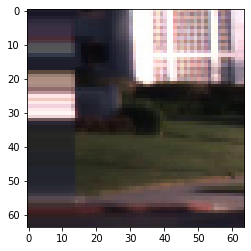

[ 0.24200657 26.483599   23.12265    32.521633   32.701904  ]


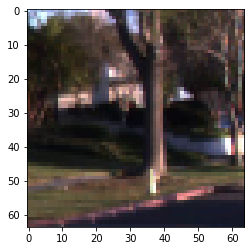

[ 0.23769888 26.255077   24.38234    32.359818   33.979782  ]


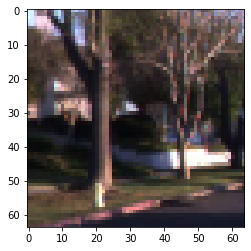

[ 0.23858598 28.498808   22.646534   34.52472    32.094135  ]


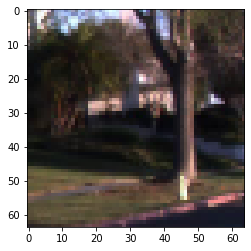

[ 0.9993466 28.523384   5.113864  39.26589   21.370096 ]


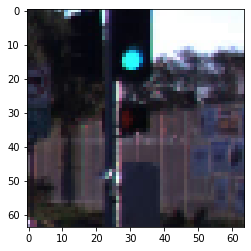

[ 0.9892632 29.157518  26.115337  41.711155  44.02561  ]


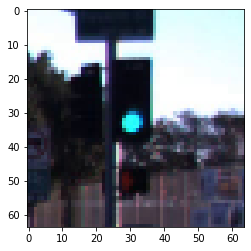

[ 0.1597558 30.756115  27.027363  36.749508  36.988136 ]


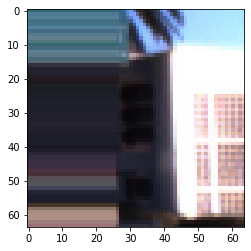

[ 0.9919465 55.112736  28.116602  61.270977  38.75197  ]


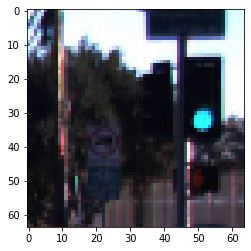

In [368]:
predictor()

In [292]:
path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/dayTrain/dayClip5/frameAnnotationsBOX.csv'
csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')
    
# choose picture 
i = random.randint(0, len(csv_file.iloc[:,0].unique()))# choose random number of picture in folder
full_pic_name = csv_file.iloc[:,0].unique()[i] # with index above choose full name picture 
pic_name = csv_file.iloc[:,0].unique()[i].split('/')[1] # with index above choose picture 
path_to_img = '/Users/stanislav/Downloads/archive/dayTrain/dayTrain/dayClip5/frames/' + pic_name
    
# print picture

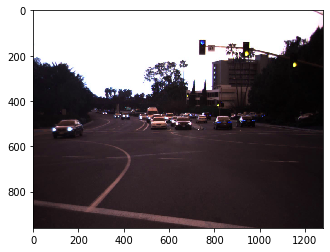

In [293]:
my_img = cv.imread(path_to_img)
plt.imshow(my_img)
plt.show()

[[2.7810931e-03 2.7688469e+01 2.6844652e+01 3.2717762e+01 3.3770359e+01]]


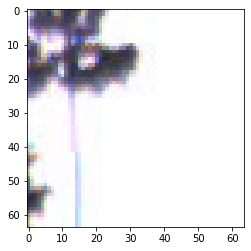

In [131]:
crop_img = my_img[230:294, 650:714]
plt.imshow(crop_img)
crop_img = np.expand_dims(crop_img, 0)
crop_img = np.array(crop_img) / 255.
print(model_one.predict(crop_img))
plt.show()

In [ ]:
plt.imshow(my_img)
plt.show()

### Next

In [215]:
def generator(batch_size=50):
    while True:
        for j in range(batch_size):
            Xs = []
            Ys = []
            count = 0
            
            while count < 100:
                
                day_or_night = random.randint(0,1)

                if day_or_night == 0: 
                    folder_day = random.randint(1,13)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/dayTrain/dayClip{}/frameAnnotationsBOX.csv'.format(folder_day)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                else:
                    folder_night = random.randint(1,5)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/nightTrain/nightClip{}/frameAnnotationsBOX.csv'.format(folder_night)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                # choose picture 
                i = random.randint(0, len(csv_file.iloc[:,0].unique())-1)# choose random number of picture in folder
                full_pic_name = csv_file.iloc[:,0].unique()[i] # with index above choose full name picture 
                pic_name = csv_file.iloc[:,0].unique()[i].split('/')[1] # with index above choose picture 

                if day_or_night == 0:
                    path_to_img = '/Users/stanislav/Downloads/archive/dayTrain/dayTrain/dayClip{}/frames/'.format(folder_day) + pic_name
                else:
                    path_to_img = '/Users/stanislav/Downloads/archive/nightTrain/nightTrain/nightClip{}/frames/'.format(folder_night) + pic_name

                img = cv.imread(path_to_img)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

                # find coordinates
                number_of_same_pic = len(csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[:,0]) # how many pic with same name
                img = cv.copyMakeBorder(img, 200, 200, 200, 200, cv.BORDER_REPLICATE) 
                
                # blobbing
                params = cv.SimpleBlobDetector_Params()
                params.minThreshold = 1
                params.maxThreshold = 255
                params.filterByArea = True
                params.minArea = 100 # for day it was 300
                #params.maxArea = 1500
                params.filterByCircularity = False
                params.filterByConvexity = False
                params.filterByInertia = False

                detector = cv.SimpleBlobDetector_create(params)
                keypoints = detector.detect(img)

                kps = np.array([key for key in keypoints])
                #print(kps)

                #im_with_keypoints = cv.drawKeypoints(img, keypoints, np.array([]), (0, 0, 255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                

                for i in range(number_of_same_pic):
                    if count < 100:
                        #appear = True
                        # coors of box
                        x1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,2]+200
                        y1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,3]+200
                        x2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,4]+200
                        y2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,5]+200
                        
                        # condition for keypoins which are not boxes - TAKES MUCH TIME
                        for key in keypoints:
                            keypoints = [key for key in keypoints if not ((x1-50 < key.pt[0] < x2+50) and (y1-50 < key.pt[1] < y2+50))]     
                        
                        random_crop_x1 = random.randint(0, 200-(x2-x1))
                        random_crop_x2 = 200 - random_crop_x1
                        random_crop_y1 = random.randint(0, 200-(y2-y1))
                        random_crop_y2 = 200 - random_crop_y1

                        cropped_img = img[y1-random_crop_y1:y2+random_crop_y2, x1-random_crop_x1:x2+random_crop_x2]
                        
                        new_x1 = random_crop_x1
                        new_y1 = random_crop_y1
                        new_x2 = new_x1 + (x2-x1)
                        new_y2 = new_y1 + (y2-y1)

                        w = cropped_img.shape[1]
                        h = cropped_img.shape[0]

                        Rx = (64 / w)
                        Ry = (64 / h)
                        
                        x1 = ceil(new_x1*Rx)
                        y1 = ceil(new_y1*Ry) 
                        x2 = ceil(new_x2*Rx)
                        y2 = ceil(new_y2*Ry)

                        cropped_img = cv.resize(cropped_img, (64, 64))
                        cropped_img = cropped_img.reshape(1, 64, 64, 3)
                        box = np.array([1, x1, y1, x2, y2], dtype=dt)
                        
                        #image_rect = cv.rectangle(cropped_img, (x1,y1), (x2,y2), (0,255,0), 1)
                        
                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)
                        #box = box.reshape(5, 1)
                        
                        count += 1
                                                        
                        #plt.imshow(image_rect)
                        #plt.show()
                keypoints = keypoints[-5:-1]
                for k in range(len(keypoints)):
                    if count < 100:
                        #appear = False
                        k_x1 = int(round(keypoints[k].pt[0]-100))
                        k_y1 = int(round(keypoints[k].pt[1]-100))
                        k_x2 = int(round(keypoints[k].pt[0]+100))
                        k_y2 = int(round(keypoints[k].pt[1]+100))

                        cropped_img = img[k_y1:k_y2, k_x1:k_x2]
                        cropped_img = cv.resize(cropped_img, (64, 64))
                        cropped_img = cropped_img.reshape(1, 64, 64, 3)

                        box = np.array([0, 0, 0, 0, 0], dtype=dt)
                        #box = box.reshape(5, 1)
                                                        
                        #plt.imshow(cropped_img)
                        #plt.show()

                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)

                        count += 1
                        
            Xs, Ys = shuffle(Xs, Ys)            
            yield Xs, Ys

In [378]:
def generator(batch_size=50):
    #while True:
        for j in range(1):
            Xs = []
            Ys = []
            count = 0
            
            while count < 10:
                
                day_or_night = random.randint(0,1)

                if day_or_night == 0: 
                    folder_day = random.randint(1,13)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/dayTrain/dayClip{}/frameAnnotationsBOX.csv'.format(folder_day)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                else:
                    folder_night = random.randint(1,5)
                    path_0 = '/Users/stanislav/Downloads/archive/Annotations/Annotations/nightTrain/nightClip{}/frameAnnotationsBOX.csv'.format(folder_night)
                    csv_file = pd.read_csv(filepath_or_buffer=path_0, sep=';')

                # choose picture 
                i = random.randint(0, len(csv_file.iloc[:,0].unique())-1)# choose random number of picture in folder
                full_pic_name = csv_file.iloc[:,0].unique()[i] # with index above choose full name picture 
                pic_name = csv_file.iloc[:,0].unique()[i].split('/')[1] # with index above choose picture 

                if day_or_night == 0:
                    path_to_img = '/Users/stanislav/Downloads/archive/dayTrain/dayTrain/dayClip{}/frames/'.format(folder_day) + pic_name
                else:
                    path_to_img = '/Users/stanislav/Downloads/archive/nightTrain/nightTrain/nightClip{}/frames/'.format(folder_night) + pic_name

                img = cv.imread(path_to_img)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

                # find coordinates
                number_of_same_pic = len(csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[:,0]) # how many pic with same name
                img = cv.copyMakeBorder(img, 200, 200, 200, 200, cv.BORDER_REPLICATE) 
                
                # blobbing
                params = cv.SimpleBlobDetector_Params()
                params.minThreshold = 1
                params.maxThreshold = 255
                params.filterByArea = True
                params.minArea = 100 # for day it was 300
                #params.maxArea = 1500
                params.filterByCircularity = False
                params.filterByConvexity = False
                params.filterByInertia = False

                detector = cv.SimpleBlobDetector_create(params)
                keypoints = detector.detect(img)

                kps = np.array([key for key in keypoints])
                #print(kps)

                #im_with_keypoints = cv.drawKeypoints(img, keypoints, np.array([]), (0, 0, 255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                

                for i in range(number_of_same_pic):
                    if count < 10:
                        #appear = True
                        # coors of box
                        x1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,2]+200
                        y1 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,3]+200
                        x2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,4]+200
                        y2 = csv_file[csv_file.iloc[:,0] == full_pic_name].iloc[i,5]+200
                        
                        # condition for keypoins which are not boxes - TAKES MUCH TIME
                        for key in keypoints:
                            keypoints = [key for key in keypoints if not ((x1-50 < key.pt[0] < x2+50) and (y1-50 < key.pt[1] < y2+50))]     
                        
                        random_crop_x1 = random.randint(0, 200-(x2-x1))
                        random_crop_x2 = 200 - random_crop_x1
                        random_crop_y1 = random.randint(0, 200-(y2-y1))
                        random_crop_y2 = 200 - random_crop_y1

                        cropped_img = img[y1-random_crop_y1:y2+random_crop_y2, x1-random_crop_x1:x2+random_crop_x2]
                        
                        new_x1 = random_crop_x1
                        new_y1 = random_crop_y1
                        new_x2 = new_x1 + (x2-x1)
                        new_y2 = new_y1 + (y2-y1)

                        w = cropped_img.shape[1]
                        h = cropped_img.shape[0]

                        Rx = (64 / w)
                        Ry = (64 / h)
                        
                        x1 = ceil(new_x1*Rx)
                        y1 = ceil(new_y1*Ry) 
                        x2 = ceil(new_x2*Rx)
                        y2 = ceil(new_y2*Ry)

                        cropped_img = cv.resize(cropped_img, (64, 64))
                        #cropped_img = cropped_img.reshape(1, 64, 64, 3)
                        box = np.array([1, x1, y1, x2, y2], dtype=dt)
                        
                        image_rect = cv.rectangle(cropped_img, (x1,y1), (x2,y2), (0,255,0), 1)
                        
                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)
                        #box = box.reshape(5, 1)
                        
                        count += 1
                                                        
                        plt.imshow(image_rect)
                        plt.show()
                keypoints = keypoints[-5:-1]
                for k in range(len(keypoints)):
                    if count < 10:
                        #appear = False
                        k_x1 = int(round(keypoints[k].pt[0]-100))
                        k_y1 = int(round(keypoints[k].pt[1]-100))
                        k_x2 = int(round(keypoints[k].pt[0]+100))
                        k_y2 = int(round(keypoints[k].pt[1]+100))

                        cropped_img = img[k_y1:k_y2, k_x1:k_x2]
                        cropped_img = cv.resize(cropped_img, (64, 64))
                        #cropped_img = cropped_img.reshape(1, 64, 64, 3)

                        box = np.array([0, 0, 0, 0, 0], dtype=dt)
                        #box = box.reshape(5, 1)
                                                        
                        plt.imshow(cropped_img)
                        plt.show()

                        Xs.append(np.array(cropped_img, dtype=dt) / 255.), Ys.append(box)

                        count += 1
                        
            #Xs, Ys = shuffle(Xs, Ys)            
            #yield Xs, Ys

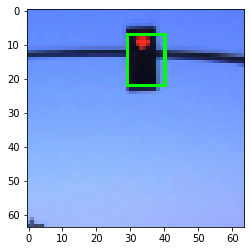

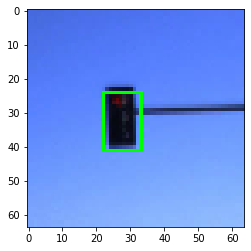

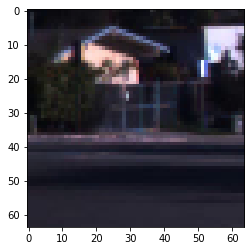

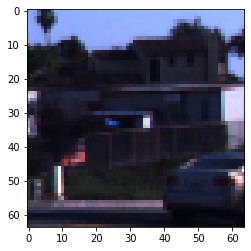

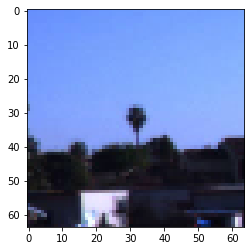

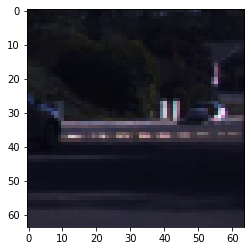

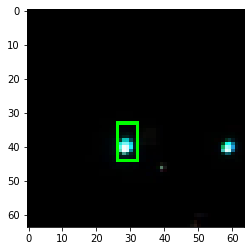

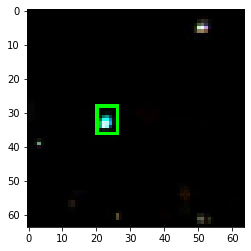

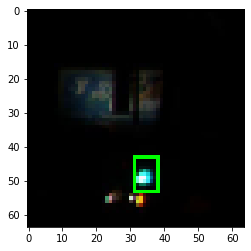

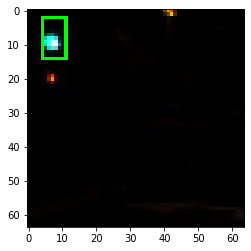

In [380]:
generator()